In [1]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib
import mahotas
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.25
seed      = 9
fixed_size       = tuple((768, 768))
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"
bins             = 5
num_classes = 3

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (15000, 145)
[STATUS] labels shape: (15000,)
[STATUS] training started...


In [2]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (11250, 145)
Test data   : (3750, 145)
Train labels: (11250,)
Test labels : (3750,)


LR: 0.927733 (0.007134)
LDA: 0.933600 (0.005364)
KNN: 0.987200 (0.002673)
CART: 0.983467 (0.002953)
RF: 0.994044 (0.001641)
NB: 0.704178 (0.010636)
SVM: 0.931022 (0.007001)


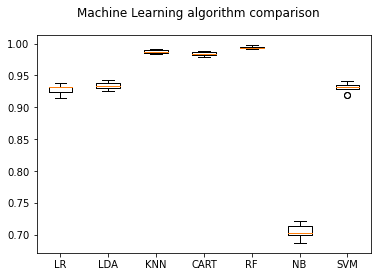

In [3]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [4]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

# create the model - SVM
clf  = clf = svm.SVC(probability=True)
#clf  = clf = svm.SVC(kernel='linear') # Linear Kernel
ovr = OneVsRestClassifier(clf)
# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)


print ("Accuracy on training set:")
print (clf.score(trainDataGlobal, trainLabelsGlobal))

print ("Accuracy on testing set:")
print (clf.score(testDataGlobal, testLabelsGlobal))

#predictions = clf.predict(rescaledY)
predictions = clf.predict(testDataGlobal)
print ("Display Summary:")
#display_summary(testDataGlobal,predictions)

cm1 = confusion_matrix(testLabelsGlobal, predictions)

print(cm1)
print(classification_report(testLabelsGlobal,predictions))

Accuracy on training set:
0.9366222222222222
Accuracy on testing set:
0.9352
Display Summary:
[[1108    1   86]
 [  40 1225    0]
 [ 116    0 1174]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1195
           1       1.00      0.97      0.98      1265
           2       0.93      0.91      0.92      1290

    accuracy                           0.94      3750
   macro avg       0.94      0.94      0.94      3750
weighted avg       0.94      0.94      0.94      3750



In [5]:
# print the first 10 predicted responses
# 1D array (vector) of binary values (0, 1)
clf.predict(testDataGlobal)[0:10]

array([1, 1, 2, 0, 2, 1, 0, 1, 2, 2], dtype=int64)

In [6]:
# print the first 10 predicted probabilities of class membership
clf.predict_proba(testDataGlobal)[0:10]

array([[4.85566558e-09, 9.99943236e-01, 5.67589096e-05],
       [8.93676597e-09, 9.99950729e-01, 4.92623753e-05],
       [1.00045115e-01, 6.22602118e-05, 8.99892625e-01],
       [9.63560840e-01, 7.16213095e-04, 3.57229465e-02],
       [1.87426572e-03, 1.34480835e-06, 9.98124389e-01],
       [2.55657020e-10, 9.99991793e-01, 8.20654948e-06],
       [9.17291606e-01, 1.98856493e-05, 8.26885080e-02],
       [2.63220900e-08, 9.99835722e-01, 1.64251458e-04],
       [1.52790400e-02, 3.87895866e-03, 9.80842001e-01],
       [7.45683630e-02, 2.31944913e-05, 9.25408442e-01]])

In [7]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(testDataGlobal)
predictions = clf.predict(testDataGlobal)
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(testLabelsGlobal, predictions,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

In [8]:
import pickle
y_pred_proba = clf.predict_proba(testDataGlobal)[::,1]
fpr, tpr, _ = metrics.roc_curve(testLabelsGlobal,  y_pred_proba,pos_label=1)

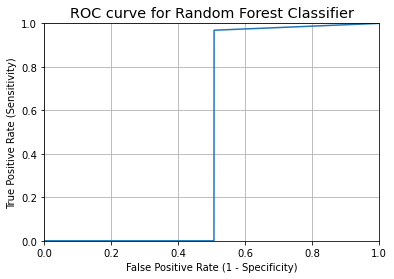

In [9]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
FPR, TPR, thresholds = metrics.roc_curve(testLabelsGlobal,predictions, pos_label=1)

plt.plot(FPR, TPR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Random Forest Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [10]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


X = np.array(global_features)
y = np.array(global_labels)
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
#random_state = np.random.RandomState(0)
#n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)
                                                                                          

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment


NameError: name 'random_state' is not defined

In [11]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

IndexError: invalid index to scalar variable.

<Figure size 432x288 with 0 Axes>

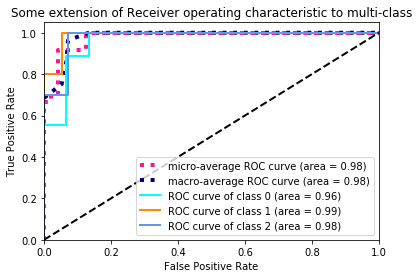

In [37]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()